In [1]:
# Install ultralytics and dependencies
!pip install -q ultralytics matplotlib scikit-learn seaborn pandas opencv-python-headless PyYAML tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.2 MB/s eta 0:00:00


In [ ]:
!rm -rf /content/e-waste-dataset

In [3]:
# Mount Google Drive and extract dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile, os, shutil
from pathlib import Path

GDRIVE_ZIP_PATH = "/content/drive/MyDrive/e-waste-dataset-4.zip"
EXTRACT_TO = Path("/content/e-waste-dataset")

if not Path(GDRIVE_ZIP_PATH).exists():
    raise FileNotFoundError(f"Zip not found at {GDRIVE_ZIP_PATH}")

if EXTRACT_TO.exists():
    shutil.rmtree(EXTRACT_TO)
with zipfile.ZipFile(GDRIVE_ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_TO)
print("Dataset extracted to", EXTRACT_TO)

Mounted at /content/drive
Dataset extracted to /content/e-waste-dataset


In [4]:
# Create data.yaml with absolute paths
import yaml

dataset_root = EXTRACT_TO
train_images = str(dataset_root / "train" / "images")
val_images   = str(dataset_root / "valid" / "images")
test_images  = str(dataset_root / "test" / "images")

class_names = ['battery', 'electronic-waste', 'keyboard', 'laptop',
               'mobile phone', 'monitor', 'mouse']

data_yaml_path = Path("/content/data_for_training.yaml")
data_for_training = {
    "train": train_images,
    "val": val_images,
    "test": test_images,
    "nc": len(class_names),
    "names": class_names
}
with open(data_yaml_path, "w") as f:
    yaml.dump(data_for_training, f, sort_keys=False)
print(open(data_yaml_path).read())

train: /content/e-waste-dataset/train/images
val: /content/e-waste-dataset/valid/images
test: /content/e-waste-dataset/test/images
nc: 7
names:
- battery
- electronic-waste
- keyboard
- laptop
- mobile phone
- monitor
- mouse



In [7]:
# Train YOLOv11 Model
from ultralytics import YOLO

EPOCHS = 30
IMGSZ = 256
BATCH = 16
MODEL_NAME = "e_waste_yolov11"

model = YOLO("yolo11n.pt")
model.train(data=str(data_yaml_path), epochs=EPOCHS, imgsz=IMGSZ,
            batch=BATCH, name=MODEL_NAME)

trained_weights = f"runs/detect/{MODEL_NAME}/weights/best.pt"
print("Training complete. Best weights at:", trained_weights)

Ultralytics 8.3.219 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data_for_training.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=e_waste_yolov113, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

In [9]:
!rm -rf /content/runs/detect/e_waste_yolov112

In [10]:
# Run evaluation
import numpy as np, cv2, time, json
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load trained model for inference
infer_model = YOLO(trained_weights)

# Helper: Load YOLO labels
def load_yolo_labels(label_path, img_w, img_h):
    objs = []
    if not os.path.exists(label_path):
        return objs
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(float(parts[0]))
            x_c, y_c, w, h = [float(x) for x in parts[1:5]]
            xmin = (x_c - w/2) * img_w
            ymin = (y_c - h/2) * img_h
            xmax = (x_c + w/2) * img_w
            ymax = (y_c + h/2) * img_h
            objs.append({'class': cls, 'bbox':[xmin, ymin, xmax, ymax]})
    return objs

def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter = max(0, xB-xA) * max(0, yB-yA)
    areaA = max(0, boxA[2]-boxA[0]) * max(0, boxA[3]-boxA[1])
    areaB = max(0, boxB[2]-boxB[0]) * max(0, boxB[3]-boxB[1])
    if areaA + areaB - inter == 0:
        return 0
    return inter / (areaA + areaB - inter)

In [11]:
# Prepare test images
test_images_dir = Path(test_images)
img_extensions = [".jpg", ".jpeg", ".png", ".bmp"]
test_files = [p for p in sorted(test_images_dir.iterdir()) if p.suffix.lower() in img_extensions]

num_classes = len(class_names)
TP, FP, FN = [0]*num_classes, [0]*num_classes, [0]*num_classes
confusion_pairs, all_gt, all_pred = [], [], []
inf_times = []

IOU_THRESHOLD = 0.5
CONF_THRESHOLD = 0.25

for img_path in tqdm(test_files, desc="Evaluating"):
    img = cv2.imread(str(img_path))
    if img is None: continue
    h, w = img.shape[:2]
    label_file = Path(str(img_path).replace("/images/", "/labels/")).with_suffix('.txt')
    gt_objs = load_yolo_labels(str(label_file), w, h)

    # Filter out ground truth objects with invalid class labels
    gt_objs = [obj for obj in gt_objs if 0 <= obj['class'] < num_classes]

    t0 = time.time()
    results = infer_model.predict(source=str(img_path), conf=CONF_THRESHOLD, iou=0.45, imgsz=IMGSZ, verbose=False)
    t1 = time.time()
    inf_times.append(t1 - t0)

    preds = []
    res = results[0]
    if res.boxes is not None:
        xyxy = res.boxes.xyxy.cpu().numpy()
        cls_arr = res.boxes.cls.cpu().numpy().astype(int)
        for b, c in zip(xyxy, cls_arr):
            # Filter out predictions with invalid class labels
            if 0 <= c < num_classes:
                preds.append({'class': c, 'bbox':[b[0], b[1], b[2], b[3]]})


    # IoU matching
    matched_gt, matched_pred = set(), set()
    iou_mat = np.zeros((len(gt_objs), len(preds)))
    for i,g in enumerate(gt_objs):
        for j,p in enumerate(preds):
            iou_mat[i,j] = iou(g['bbox'], p['bbox'])

    while iou_mat.size > 0 and np.max(iou_mat) >= IOU_THRESHOLD:
        gi,pj = np.unravel_index(np.argmax(iou_mat), iou_mat.shape)
        gt_cls, pred_cls = gt_objs[gi]['class'], preds[pj]['class']
        if gt_cls == pred_cls:
            TP[gt_cls]+=1
        else:
            FP[pred_cls]+=1; FN[gt_cls]+=1
        confusion_pairs.append((gt_cls, pred_cls))
        all_gt.append(gt_cls); all_pred.append(pred_cls)
        matched_gt.add(gi); matched_pred.add(pj)
        iou_mat[gi,:] = -1; iou_mat[:,pj] = -1

    # Unmatched predictions → false positives
    for j in range(len(preds)):
        if j not in matched_pred:
            FP[preds[j]['class']]+=1
            all_gt.append(-1)
            all_pred.append(preds[j]['class'])

    # Unmatched ground truths → false negatives
    for i in range(len(gt_objs)):
        if i not in matched_gt:
            FN[gt_objs[i]['class']]+=1
            all_gt.append(gt_objs[i]['class'])
            all_pred.append(-1)

Evaluating: 100%|██████████| 445/445 [00:05<00:00, 77.11it/s]


In [12]:
# Evaluation Metrics
precision, recall, f1, support = [],[],[],[]
for c in range(num_classes):
    tp,fp,fn = TP[c],FP[c],FN[c]
    p = tp/(tp+fp) if tp+fp>0 else 0
    r = tp/(tp+fn) if tp+fn>0 else 0
    f = (2*p*r)/(p+r) if (p+r)>0 else 0
    precision.append(p); recall.append(r); f1.append(f); support.append(tp+fn)

accuracy = sum(TP) / (sum(TP)+sum(FP)+sum(FN)) if (sum(TP)+sum(FP)+sum(FN))>0 else 0
avg_latency = np.mean(inf_times) if inf_times else float('nan')


==== Evaluation Summary (YOLOv11) ====
Avg latency (s/img): 0.0121
Accuracy: 0.1420
Precision: 0.3356
Recall: 0.2946
F1-Score:0.2585


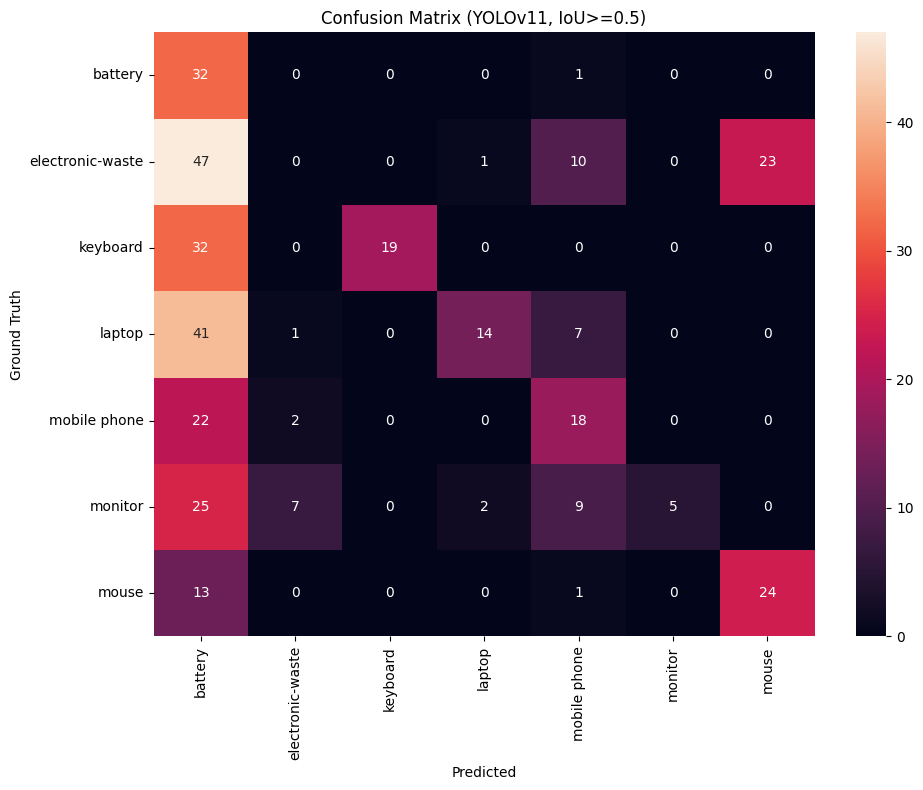

In [13]:
# Build confusion matrix
cm = confusion_matrix(all_gt, all_pred, labels=list(range(num_classes)) + [-1])

# Display Evaluation Summary
print("\n==== Evaluation Summary (YOLOv11) ====")
print(f"Avg latency (s/img): {avg_latency:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall: {np.mean(recall):.4f}")
print(f"F1-Score:{np.mean(f1):.4f}")

# Plot confusion matrix
cm_display = cm[:-1,:-1]
plt.figure(figsize=(10,8))
sns.heatmap(cm_display, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (YOLOv11, IoU>=0.5)")
plt.tight_layout()
plt.savefig("/content/confusion_matrix_yolov11.png", dpi=200)
plt.show()

In [14]:
!zip -r /content/YOLO11.zip /content/runs

from google.colab import files
files.download("/content/YOLO11.zip")

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/e_waste_yolov112/ (stored 0%)
  adding: content/runs/detect/e_waste_yolov112/train_batch0.jpg (deflated 4%)
  adding: content/runs/detect/e_waste_yolov112/val_batch2_pred.jpg (deflated 23%)
  adding: content/runs/detect/e_waste_yolov112/val_batch1_pred.jpg (deflated 23%)
  adding: content/runs/detect/e_waste_yolov112/train_batch2.jpg (deflated 4%)
  adding: content/runs/detect/e_waste_yolov112/BoxR_curve.png (deflated 8%)
  adding: content/runs/detect/e_waste_yolov112/val_batch0_labels.jpg (deflated 23%)
  adding: content/runs/detect/e_waste_yolov112/train_batch1.jpg (deflated 7%)
  adding: content/runs/detect/e_waste_yolov112/BoxPR_curve.png (deflated 11%)
  adding: content/runs/detect/e_waste_yolov112/results.png (deflated 22%)
  adding: content/runs/detect/e_waste_yolov112/val_batch1_labels.jpg (deflated 24%)
  adding: content/runs/detect/e_waste_yolov112/val_batch0_pred.jpg 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>